In [1]:
!pip install hls4ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.3/572.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyparser: filename=pyparser-1.0-py3-none-any.whl size=4915 sha256=86742220034a7d74b5708579b637b58da99d99adc2ac4abf133fe047f6d87d83
  Stored in directory: /root/.cache/pip/wheels/25/87/78/ff95e8a747dc534fbd199fb3ea06d80935bc87e44567bbdb31
  Created wheel for parse: filename=parse-1.6.5-py3-none-any.whl size=18155 sha256=0e5f

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import hls4ml
import shutil
import os
import random

#torch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torchvision.utils as vutils

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchvision import models
from torchsummary import summary

import h5py

In [4]:
class BabyYOLO(nn.Module):
    def __init__(self):
        super(BabyYOLO, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2)
        self.bn4 = nn.BatchNorm2d(16)

        self.prob_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.box_conv = nn.Conv2d(16, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.bn1(self.pool1(self.act1(self.conv1(x))))
        x = self.bn2(self.pool2(self.act2(self.conv2(x))))
        x = self.bn3(self.pool3(self.act3(self.conv3(x))))
        x = self.bn4(self.pool4(self.act4(self.conv4(x))))

        prob = torch.sigmoid(self.prob_conv(x))
        gate = torch.where(prob > 0.5, torch.ones_like(prob), torch.zeros_like(prob))
        boxes = self.box_conv(x) * gate

        return torch.cat((prob, boxes), dim=1)

# Define the model
model = BabyYOLO()


In [5]:
class HardwareBabyYOLO(nn.Module):
    def __init__(self):
        super(HardwareBabyYOLO, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2)
        self.bn4 = nn.BatchNorm2d(16)

        self.prob_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.box_conv = nn.Conv2d(16, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.bn1(self.pool1(self.act1(self.conv1(x))))
        x = self.bn2(self.pool2(self.act2(self.conv2(x))))
        x = self.bn3(self.pool3(self.act3(self.conv3(x))))
        x = self.bn4(self.pool4(self.act4(self.conv4(x))))

        prob = torch.sigmoid(self.prob_conv(x))
        boxes = self.box_conv(x)

        return torch.cat((prob, boxes), dim=1)

In [6]:
summary(model, (1, 128, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 128, 48]             160
              ReLU-2          [-1, 16, 128, 48]               0
         MaxPool2d-3           [-1, 16, 64, 24]               0
       BatchNorm2d-4           [-1, 16, 64, 24]              32
            Conv2d-5           [-1, 16, 64, 24]           2,320
              ReLU-6           [-1, 16, 64, 24]               0
         MaxPool2d-7           [-1, 16, 32, 12]               0
       BatchNorm2d-8           [-1, 16, 32, 12]              32
            Conv2d-9           [-1, 16, 32, 12]           2,320
             ReLU-10           [-1, 16, 32, 12]               0
        MaxPool2d-11            [-1, 16, 16, 6]               0
      BatchNorm2d-12            [-1, 16, 16, 6]              32
           Conv2d-13            [-1, 16, 16, 6]           2,320
             ReLU-14            [-1, 16

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

grid_size = 16  # image_size / mask_size
num_channels = 5  # Number of channels in YOLO output

def make_gaussians(X, y):
    """
    Generates a new data sample by placing random Gaussian blobs around a 29x48 frame
    Adds random noise to the image and additional noise near the centers of the Gaussians

    :param X: New empty YOLO data array
    :param y: New empty YOLO labels data array
    """

    num_gaussian = np.random.randint(2, 4)  # randomly choose the number of gaussian to generate (between 1 and 5)

    for _ in range(num_gaussian):  # iterate over the number of gaussians

        cx, cy = np.random.randint(0, 128), np.random.randint(0, 48)  # generate a random center for the gaussian
        std_dev_x, std_dev_y = np.random.randint(2, 9), np.random.randint(1, 8)  # random standard deviations for x and y
        std_dev_x, std_dev_y = float(std_dev_x), float(std_dev_y)

        x_coords = np.arange(128)
        y_coords = np.arange(48)
        xx, yy = np.meshgrid(x_coords, y_coords)  # Create a meshgrid covering the entire image

        # Calculate Gaussian using provided formula
        gaussian = np.exp(-((xx - cx) ** 2 / (2 * std_dev_x ** 2) + (yy - cy) ** 2 / (2 * std_dev_y ** 2)))
        gaussian = gaussian[np.newaxis, ...]  # Add a new axis for channel
        X += gaussian

        # Compute bounding box coordinates
        mx, my = cx // 16 % (128 // 16), cy // 16 % (48 // 16)

        channels = y[:, my, mx]

        if channels[0] > 0:
            continue

        channels[0] = 1.0
        channels[1] = (cx - 3 * std_dev_x) - (mx * grid_size)  # x1 - increase bounding box size
        channels[2] = (cy - 3 * std_dev_y) - (my * grid_size)  # y1 - increase bounding box size
        channels[3] = (cx + 3 * std_dev_x) - (mx * grid_size)  # x2 - increase bounding box size
        channels[4] = (cy + 3 * std_dev_y) - (my * grid_size)  # y2 - increase bounding box size

        # Calculate bounding box coordinates
        x1 = channels[1]
        y1 = channels[2]
        x2 = channels[3]
        y2 = channels[4]

        # Apply default values if conditions are met
        if x1 < 0:
            x1 = 0
        if x2 > 127:
            x2 = 127
        if y1 < 0:
            y1 = 0
        if y2 > 47:
            y2 = 47

        # Update channels with the corrected values
        channels[1] = x1
        channels[2] = y1
        channels[3] = x2
        channels[4] = y2

    # Add random noise to the image
    noise_level = 0.25  # Adjust the noise level as needed
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
    X += noise

    # Add noise near the centers of the Gaussians
    center_noise_level = 0.3  # Adjust the noise level near the centers as needed
    for cx, cy in zip(np.random.randint(0, 128, size=num_gaussian), np.random.randint(0, 48, size=num_gaussian)):
        # Generate noise centered around the Gaussian centers
        center_noise = np.exp(-((xx - cx) ** 2 + (yy - cy) ** 2) / (2 * 5 ** 2))  # Larger standard deviation for more intense noise
        center_noise *= center_noise_level  # Scale the intensity of the noise
        center_noise = center_noise[np.newaxis, ...]
        X += center_noise

    # Clip the image to keep pixel values within valid range
    X = np.clip(X, 0.0, 1.0)

def make_data(size):
    """
    Generates a new dataset for YOLO training

    :param size: Number of samples to generate for training, can be larger than MNIST dataset
    :return: New dataset and labels
    """

    X = np.zeros((size, 1, 48, 128), dtype=np.float32)  # New data sample of 48x128 with 1 channel
    y = np.zeros((size, num_channels, 3, 8), dtype=np.float32)  # New data output consists of probability and bounding box

    # Generate data
    for i in range(size):
        make_gaussians(X[i], y[i])

    X = np.clip(X, 0.0, 1.0)
    return X, y

def show_predict(X, y, threshold=0.6):
    """
    Display single prediction results

    :param X: Data sample input
    :param y: Model predictions
    :param threshold: Probability threshold
    """
    output_coords = []
    print("empty:" + str(output_coords))
    X = X.copy()
    for mx in range(8):
        for my in range(3):
            channels = y[:, my, mx]
            prob, x1, y1, x2, y2 = channels[:5]

            #if prob < threshold we won't show any thing
            if prob < threshold:
                continue

            color = 255
            # bounding box
            px, py = (mx * grid_size) + x1, (my * grid_size) + y1
            cv2.rectangle(X, (int(px), int(py)), (int(px + x2), int(py + y2)), -1, 1)

            out_coords = [int(px), int(px + x2), int(py), int(py + y2)]
            output_coords.append(out_coords)

            print("prob: " + str(prob) + ", x1: " + str(int(px)) + ", y1: " + str(int(py)) + ", x2: " + str(int(px + x2)) + ", y2: " + str(int(py + y2)))

    plt.imshow(X, cmap="gray")
    return output_coords

X shape: (1, 1, 48, 128)
y shape: (1, 5, 3, 8)
empty:[]
prob: 1.0, x1: 0, y1: 32, x2: 29, y2: 56
prob: 1.0, x1: 89, y1: 18, x2: 110, y2: 26
[[0, 29, 32, 56], [89, 110, 18, 26]]


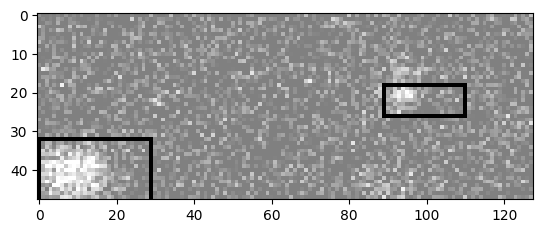

In [14]:
# Generate test image
X, y = make_data(1)
print("X shape:", X.shape)
print("y shape:", y.shape)

out = show_predict(X[0][0], y[0])
print(out)

In [8]:
from tqdm import tqdm

idx_p = [0] # probability
idx_bb = [1, 2, 3, 4] # bounding box

def loss_funcs(y_true, y_pred):
    # Extract individual components from the prediction
    y_prob_pred = y_pred[:, 0:1, :, :]
    y_boxes_pred = y_pred[:, 1:5, :, :]

    # Extract individual components from the ground truth
    y_prob_true = y_true[:, 0:1, :, :]
    y_boxes_true = y_true[:, 1:5, :, :]

    # Probability loss
    loss_p = F.binary_cross_entropy(y_prob_pred, y_prob_true)

    # Bounding boxes loss
    loss_bb = F.mse_loss(y_boxes_pred, y_boxes_true)

    # Combine losses
    loss_total = loss_p + loss_bb

    return loss_total

opt = torch.optim.Adam(model.parameters(), lr=0.003)

def train_step(model, optimizer, x, y):
    model.zero_grad()
    pred = model(x)
    loss = loss_funcs(y, pred)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training function
def train_model(model, optimizer, train_loader, num_epochs=5):
    model.train()
    total_batches = len(train_loader)
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        with tqdm(total=total_batches, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
            for batch_idx, (x, y) in enumerate(train_loader):
                x, y = x.to(device), y.to(device)  # Move data to GPU if available
                loss = train_step(model, optimizer, x, y)
                epoch_loss += loss

                # Update progress bar
                pbar.set_postfix({'Loss': loss})
                pbar.update(1)

        epoch_loss /= total_batches
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

In [9]:
batch_size = 32
X_train, y_train = make_data(size=batch_size * 400)
print(X_train.shape)
print(y_train.shape)

(12800, 1, 48, 128)
(12800, 5, 3, 8)


In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
# Test the DataLoader
data_iter = iter(train_loader)
inputs, targets = next(data_iter)
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")

Input shape: torch.Size([32, 1, 48, 128])
Target shape: torch.Size([32, 5, 3, 8])


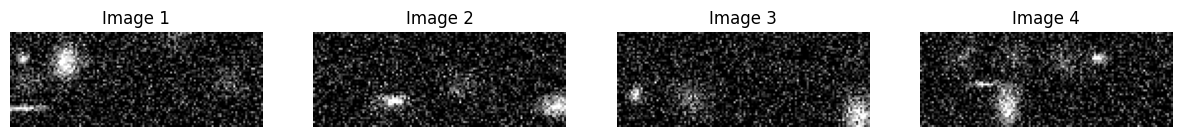

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_iter = iter(train_loader)
inputs, targets = next(data_iter)

# Plot the first 4 images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    image = inputs[i].squeeze().numpy()  # Assuming input images are of shape (batch_size, height, width, channels)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.show()

In [17]:
train_model(model, opt, train_loader)

Epoch 1/5: 100%|██████████| 400/400 [00:47<00:00,  8.37batch/s, Loss=26.2]


Epoch [1/5], Loss: 26.5178


Epoch 2/5: 100%|██████████| 400/400 [00:48<00:00,  8.27batch/s, Loss=26.8]


Epoch [2/5], Loss: 26.5186


Epoch 3/5: 100%|██████████| 400/400 [00:47<00:00,  8.46batch/s, Loss=25.3]


Epoch [3/5], Loss: 26.5181


Epoch 4/5: 100%|██████████| 400/400 [00:47<00:00,  8.50batch/s, Loss=26.6]


Epoch [4/5], Loss: 26.5181


Epoch 5/5: 100%|██████████| 400/400 [00:47<00:00,  8.43batch/s, Loss=24.3]

Epoch [5/5], Loss: 26.5183


In [18]:
torch.save(model.state_dict(), 'FOLO.pt')

empty:[]
prob: tensor(1., grad_fn=<UnbindBackward0>), x1: 32, y1: 33, x2: 70, y2: 68


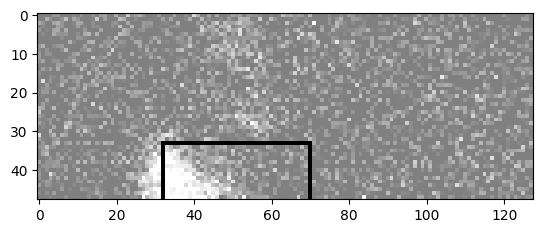

In [23]:
def get_regions(numbers=None, threshold=0.1):
    """
    View single model prediction

    :param threshold: Probability threshold
    """

    X, y = make_data(size=1)
    X_tensor = torch.tensor(X)
    y = model(X_tensor)
    coords = show_predict(X[0][0], y[0], threshold=threshold)


tensors = get_regions(threshold=0.4)

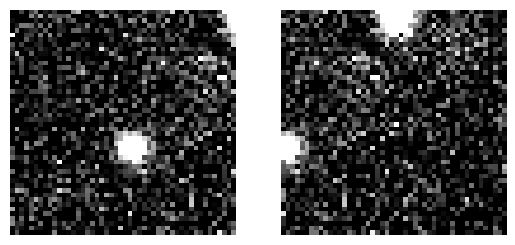

In [ ]:
for i in range(len(tensors)):
    plt.subplot(1, len(tensors), i+1)
    plt.imshow(tensors[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [14]:
class LeNet5(nn.Module):
     def __init__(self,num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(144, 98)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(98, 52)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(52, num_classes)
        self.flatten=nn.Flatten()

     def forward(self, x):

        out = self.layer1(x)

        out = self.layer2(out)

        out=self.flatten(out)

        out = self.fc(out)

        out = self.relu(out)
        out = self.fc1(out)

        out = self.relu1(out)
        embedding = self.fc2(out)



        return embedding

In [19]:
model_lenet=LeNet5(5)
model_lenet.load_state_dict(torch.load('PytorchLeNet_4848.pt', map_location=torch.device('cpu')))
model_lenet.eval()

model = HardwareBabyYOLO()
model.load_state_dict(torch.load('FOLO.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [40]:
class MyCombined(nn.Module):
    def __init__(self, my_pretrained_model1, my_pretrained_model2):
        super(MyCombined, self).__init__()
        self.pretrained1 = my_pretrained_model1
        self.pretrained2 = my_pretrained_model2
        self.conv = nn.Conv2d(in_channels=5, out_channels=1, kernel_size=3, stride=1, padding=23)


        # Sixth Conv Layer: Final adjustment to achieve exact (48, 48)
        self.conv6 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(7, 4), stride=1, padding=(1, 2))  # Keeps the shape

    def forward(self, x):
        x = self.pretrained1(x)
        x = self.conv(x)

        x = self.conv6(x)
        x = self.pretrained2(x)
        return x


combined_model = MyCombined(my_pretrained_model1 = model, my_pretrained_model2 = model_lenet)
combined_model.eval()

MyCombined(
  (pretrained1): HardwareBabyYOLO(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act3): ReLU()
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act4): ReLU()
    (pool4): MaxPool2d(ke

In [41]:
summary(combined_model, (1, 128, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 128, 48]             160
              ReLU-2          [-1, 16, 128, 48]               0
         MaxPool2d-3           [-1, 16, 64, 24]               0
       BatchNorm2d-4           [-1, 16, 64, 24]              32
            Conv2d-5           [-1, 16, 64, 24]           2,320
              ReLU-6           [-1, 16, 64, 24]               0
         MaxPool2d-7           [-1, 16, 32, 12]               0
       BatchNorm2d-8           [-1, 16, 32, 12]              32
            Conv2d-9           [-1, 16, 32, 12]           2,320
             ReLU-10           [-1, 16, 32, 12]               0
        MaxPool2d-11            [-1, 16, 16, 6]               0
      BatchNorm2d-12            [-1, 16, 16, 6]              32
           Conv2d-13            [-1, 16, 16, 6]           2,320
             ReLU-14            [-1, 16

In [42]:
test = hls4ml.converters.get_supported_pytorch_layers()
print('View' in test)

True


In [43]:
#changing around reuse values

OUT_DIR = f'combined_models_rheed'

def print_dict(d, indent=0):
    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))


config = hls4ml.utils.config_from_pytorch_model(combined_model, inputs_channel_last=True,transpose_outputs=False,default_reuse_factor=2, granularity = "name")


print_dict(config)

hls_model = hls4ml.converters.convert_from_pytorch_model(combined_model,
                                                      [[None,1,128,48]],
                                                       hls_config = config,
                                                       io_type = 'io_stream',
                                                       output_dir = OUT_DIR,
                                                       part='xcku035-fbva676-2-e'
                                                       )
hls_model.compile()

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       2
  InputsChannelLast: True
  TransposeOutputs:  False
  Strategy:          Latency
Interpreting Model ...


TraceError: Proxy object cannot be iterated. This can be attempted when the Proxy is used in a loop or as a *args or **kwargs function argument. See the torch.fx docs on pytorch.org for a more detailed explanation of what types of control flow can be traced, and check out the Proxy docstring for help troubleshooting Proxy iteration errors